# 1. Thêm các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split

# 2. Đọc dữ liệu VRTX

In [2]:
df = pd.read_csv('../Datasets/VRTX_processed.csv')
df1 = df.reset_index()['Close']

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [4]:
choose = 1  # 1, 2

if choose == 1:
    # 7:3 ratio for train:testS
    train_size = int(0.7 * len(df1))
    test_size = len(df1) - train_size

    train_data = df1[:train_size]
    test_data = df1[train_size:]

elif choose == 2:
    # 6:4 ratio for train:test
    train_size = int(0.6 * len(df1))
    test_size = len(df1) - train_size

    train_data = df1[:train_size]
    test_data = df1[train_size:]

elif choose == 3:
    # 8:2 ratio for train:test
    train_size = int(0.8 * len(df1))
    test_size = len(df1) - train_size

    train_data = df1[:train_size]
    test_data = df1[train_size:]

print("Train: ", train_size)
print("Test: ", test_size)


Train:  1278
Test:  549


In [5]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [6]:
X_train.shape

(1177, 100)

# 3. Triển khai mô hình

## 3.1 Mô hình Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [8]:
# Khởi tạo mô hình RandomForestRegressor
# rf_model = RandomForestRegressor()
# grid_rf = {
# 'n_estimators': [20, 50, 100, 500],
# 'max_depth': np.arange(1, 15, 1),
# 'min_samples_split': [2, 10, 9],
# 'min_samples_leaf': np.arange(1, 15, 2, dtype=int),
# 'bootstrap': [True, False],
# 'random_state': [1, 2, 30, 42]
# }

# rscv = RandomizedSearchCV(estimator=rf_model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
# rscv_fit = rscv.fit(X_train, y_train)
# best_parameters = rscv_fit.best_params_

# print("Best parameters found: ", best_parameters)

In [9]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [10]:
rf_train_predict = rf_model.predict(X_train)
rf_y_pred = rf_model.predict(X_test)

### Dự đoán 90 ngày tiếp theo

In [11]:
time_step = 100 
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
rf_lst_output_90 = []
i = 0
while i < 90:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step))
        yhat = rf_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        rf_lst_output_90.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step))
        yhat = rf_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        rf_lst_output_90.extend(yhat.tolist())
        i += 1

rf_lst_output_90 = np.array(rf_lst_output_90).reshape(-1, 1)

## 3.2 Mô hình Support Vector Regressor

In [12]:
from sklearn.svm import SVR

In [13]:
# svr_model = SVR()

# grid_svr = {
# 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
# 'C': [0.1, 1, 10, 100],
# 'gamma': ['scale', 'auto'],
# 'degree': np.arange(2, 5, 1) 
# }
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# rscv_svr = RandomizedSearchCV(estimator=svr_model, param_distributions=grid_svr, cv=3, n_jobs=-1, verbose=2, n_iter=200)
# rscv_svr_fit = rscv_svr.fit(X_train, y_train)
# best_parameters = rscv_svr_fit.best_params_

# print("Best parameters found: ", best_parameters)

In [14]:
svr_model = SVR()
svr_model.fit(X_train, y_train)

SVR()

In [15]:
# Dự đoán trên tập huấn luyện, tập kiểm tra và tập xác thực
svr_train_predict = svr_model.predict(X_train)
svr_y_pred = svr_model.predict(X_test)

### Dự báo cho 90 ngày tiếp theo

In [16]:
time_step = 100 
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
svr_lst_output_90 = []
i = 0
while i < 90:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step))
        yhat = svr_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        svr_lst_output_90.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step))
        yhat = svr_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        svr_lst_output_90.extend(yhat.tolist())
        i += 1

svr_lst_output_90 = np.array(svr_lst_output_90).reshape(-1, 1)


## 3.3 Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [19]:
# Dự đoán trên tập huấn luyện, tập kiểm tra và tập xác thực
lr_train_predict = lr_model.predict(X_train)
lr_y_pred = lr_model.predict(X_test)

In [20]:
time_step = 100 
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lr_lst_output_90 = []
i = 0
while i < 90:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step))
        yhat = svr_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        lr_lst_output_90.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step))
        yhat = svr_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lr_lst_output_90.extend(yhat.tolist())
        i += 1

lr_lst_output_90 = np.array(lr_lst_output_90).reshape(-1, 1)


## 3.4 Mô hình Stacking

In [21]:
from sklearn.ensemble import StackingRegressor

## StackingSVR

In [22]:
#Xây dựng base model
base_models = [
    # ('rf', rf_model),
    ('svr', svr_model)
]
meta_model = lr_model

In [23]:
# Khởi tạo mô hình Stacking với các base model
stackingSVR_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model
)

In [24]:
# Huấn luyện mô hình stacking
stackingSVR_model.fit(X_train, y_train)

StackingRegressor(estimators=[('svr', SVR())],
                  final_estimator=LinearRegression())

In [25]:
#Dự đoán
stackingSVR_train_predict = stackingSVR_model.predict(X_train)
stackingSVR_y_pred = stackingSVR_model.predict(X_test)

In [26]:
stackingSVR_y_pred

array([0.35297267, 0.3541888 , 0.35107982, 0.35123452, 0.34959398,
       0.34751074, 0.34586802, 0.34304642, 0.33844414, 0.33562964,
       0.33218268, 0.33239243, 0.33252776, 0.33211737, 0.33087693,
       0.3271192 , 0.3235872 , 0.32200268, 0.3214534 , 0.3207475 ,
       0.31897323, 0.31639306, 0.31377858, 0.31012958, 0.30975071,
       0.30768817, 0.30422913, 0.30158071, 0.29764238, 0.2949385 ,
       0.29601618, 0.29607167, 0.29356085, 0.29017831, 0.28809713,
       0.28772952, 0.28618287, 0.28769684, 0.28907047, 0.28740874,
       0.28597762, 0.28530459, 0.28465658, 0.28346111, 0.28125558,
       0.28243759, 0.2825868 , 0.28266484, 0.2819874 , 0.28071697,
       0.28244927, 0.28073786, 0.27729424, 0.27754539, 0.2790667 ,
       0.28062472, 0.28218317, 0.28207612, 0.28283125, 0.27948234,
       0.28095588, 0.28230588, 0.28392586, 0.28333302, 0.28376462,
       0.28496345, 0.28609199, 0.28578383, 0.28430701, 0.28358759,
       0.28326607, 0.2820859 , 0.28174178, 0.28245126, 0.28218

### Dự đoán 90 ngày tiếp theo

In [27]:
# Dự đoán 90 ngày tiếp theo
time_step = 100  # Giả sử bạn đang sử dụng 100 bước thời gian
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
stackingSVR_lst_output_90 = []
i = 0

while i < 90:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step))
        yhat = stackingSVR_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        stackingSVR_lst_output_90.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step))
        yhat = stackingSVR_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        stackingSVR_lst_output_90.extend(yhat.tolist())
        i += 1

stackingSVR_lst_output_90 = np.array(stackingSVR_lst_output_90).reshape(-1, 1)


## StackingRandomForest

In [28]:
#Xây dựng base model
base_models = [
    ('rf', rf_model)
]
meta_model = lr_model

In [29]:
# Khởi tạo mô hình Stacking với các base model
stackingRF_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model
)

In [30]:
# Huấn luyện mô hình stacking
stackingRF_model.fit(X_train, y_train)

StackingRegressor(estimators=[('rf', RandomForestRegressor())],
                  final_estimator=LinearRegression())

In [31]:
#Dự đoán
stackingRF_train_predict = stackingRF_model.predict(X_train)
stackingRF_y_pred = stackingRF_model.predict(X_test)

In [32]:
stackingRF_y_pred

array([0.48430979, 0.48460838, 0.48474137, 0.48460838, 0.48574502,
       0.48569257, 0.48513249, 0.48460838, 0.4842491 , 0.48444166,
       0.48394415, 0.47815004, 0.46845935, 0.47141785, 0.45302626,
       0.47438758, 0.44316249, 0.44227423, 0.43536559, 0.4319905 ,
       0.42850077, 0.42530663, 0.44006501, 0.43558063, 0.43305072,
       0.428524  , 0.42817859, 0.42544937, 0.42824152, 0.43235539,
       0.44912781, 0.43316948, 0.42314237, 0.41403124, 0.43853537,
       0.4760903 , 0.48249506, 0.48665014, 0.48701278, 0.48619046,
       0.48592971, 0.48801081, 0.48727316, 0.48725967, 0.48565024,
       0.4854528 , 0.48372873, 0.48456492, 0.4828888 , 0.48010189,
       0.47898098, 0.47793575, 0.47602886, 0.47752365, 0.47774206,
       0.47602136, 0.47556431, 0.47861084, 0.47787394, 0.47699392,
       0.47740264, 0.47889444, 0.47956953, 0.46655246, 0.46486885,
       0.47712129, 0.47900383, 0.47931853, 0.47835721, 0.48159406,
       0.47777878, 0.46408586, 0.47091659, 0.47389081, 0.47651

### Dự đoán 90 ngày tiếp theo

In [33]:
# Dự đoán 90 ngày tiếp theo
time_step = 100  # Giả sử bạn đang sử dụng 100 bước thời gian
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
stackingRF_lst_output_90 = []
i = 0

while i < 90:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step))
        yhat = stackingRF_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        stackingRF_lst_output_90.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step))
        yhat = stackingRF_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        stackingRF_lst_output_90.extend(yhat.tolist())
        i += 1

stackingRF_lst_output_90 = np.array(stackingRF_lst_output_90).reshape(-1, 1)


# 4. Đánh giá mô hình

## 4.1 Đánh giá các chỉ số RMSE, MAE, MAPE trên tập test

In [34]:
list_mectrics_test = {
    'Model': ['Random Forest', 'SVR', 'LR', 'StackingSVR', 'StackingRF'],
    'MAE': [round(metrics.mean_absolute_error(y_test, rf_y_pred), 4),
            round(metrics.mean_absolute_error(y_test, svr_y_pred), 4),
            round(metrics.mean_absolute_error(y_test, lr_y_pred), 4),
            round(metrics.mean_absolute_error(y_test, stackingSVR_y_pred), 4),
            round(metrics.mean_absolute_error(y_test, stackingRF_y_pred), 4)],
    'RMSE': [round(np.sqrt(round(metrics.mean_squared_error(y_test, rf_y_pred), 4)), 4),
             round(np.sqrt(round(metrics.mean_squared_error(y_test, svr_y_pred), 4)), 4),
             round(np.sqrt(round(metrics.mean_squared_error(y_test, lr_y_pred), 4)), 4),
             round(np.sqrt(round(metrics.mean_squared_error(y_test, stackingSVR_y_pred), 4)), 4),
             round(np.sqrt(round(metrics.mean_squared_error(y_test, stackingRF_y_pred), 4)), 4)],
    'MAPE(%)': [round(metrics.mean_absolute_percentage_error(y_test, rf_y_pred)*100, 4),
             round(metrics.mean_absolute_percentage_error(y_test, svr_y_pred)*100, 4),
             round(metrics.mean_absolute_percentage_error(y_test, lr_y_pred)*100, 4),
             round(metrics.mean_absolute_percentage_error(y_test, stackingSVR_y_pred)*100, 4),
             round(metrics.mean_absolute_percentage_error(y_test, stackingRF_y_pred)*100, 4)]
}

df_test = pd.DataFrame(list_mectrics_test)

print(df_test)


           Model     MAE    RMSE  MAPE(%)
0  Random Forest  0.1797  0.2263  24.3185
1            SVR  0.3884  0.4211  56.8420
2             LR  0.0105  0.0173   1.6484
3    StackingSVR  0.3929  0.4286  57.2759
4     StackingRF  0.1763  0.2234  23.7679


# 5. Trực quan

## 5.1 Mô hình Random Forest 

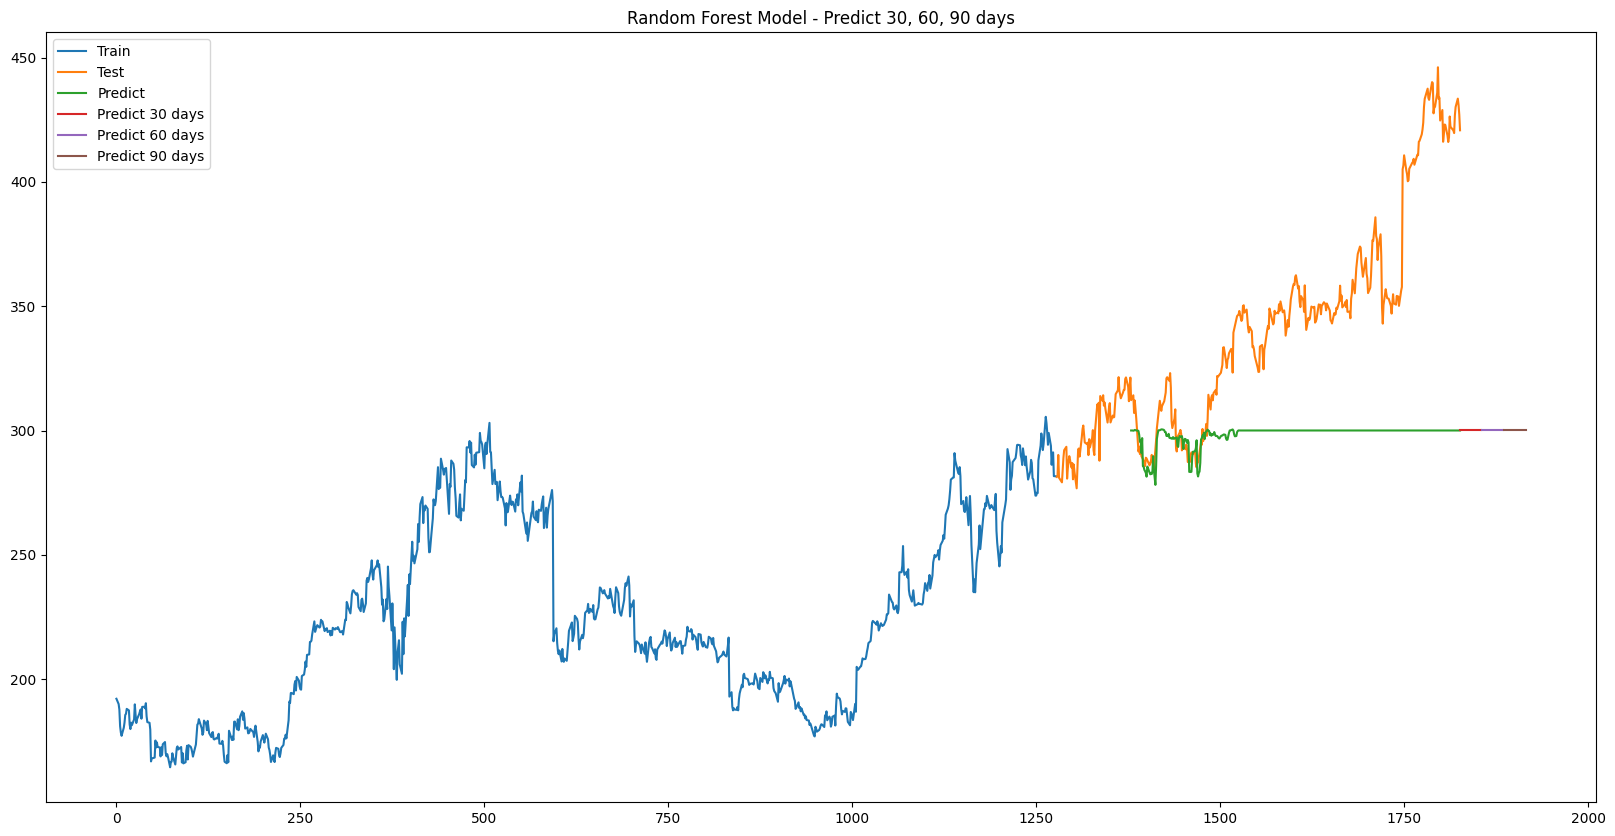

In [35]:
plt.figure(figsize=(20, 10))

# Plot training data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Plot testing data
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Plot predictions on the test set
test_pred_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(rf_y_pred.reshape(-1, 1)), label='Predict')

# Plot the next 90 days predictions, divided into three segments
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30, scaler.inverse_transform(rf_lst_output_90[:30]), label='Predict 30 days')

predict_data_index_60 = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60, scaler.inverse_transform(rf_lst_output_90[30:60]), label='Predict 60 days')

predict_data_index_90 = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90, scaler.inverse_transform(rf_lst_output_90[60:90]), label='Predict 90 days')

# Add legend and title
plt.legend()
plt.title("Random Forest Model - Predict 30, 60, 90 days")
plt.show()


## 5.2 Mô hình SVR

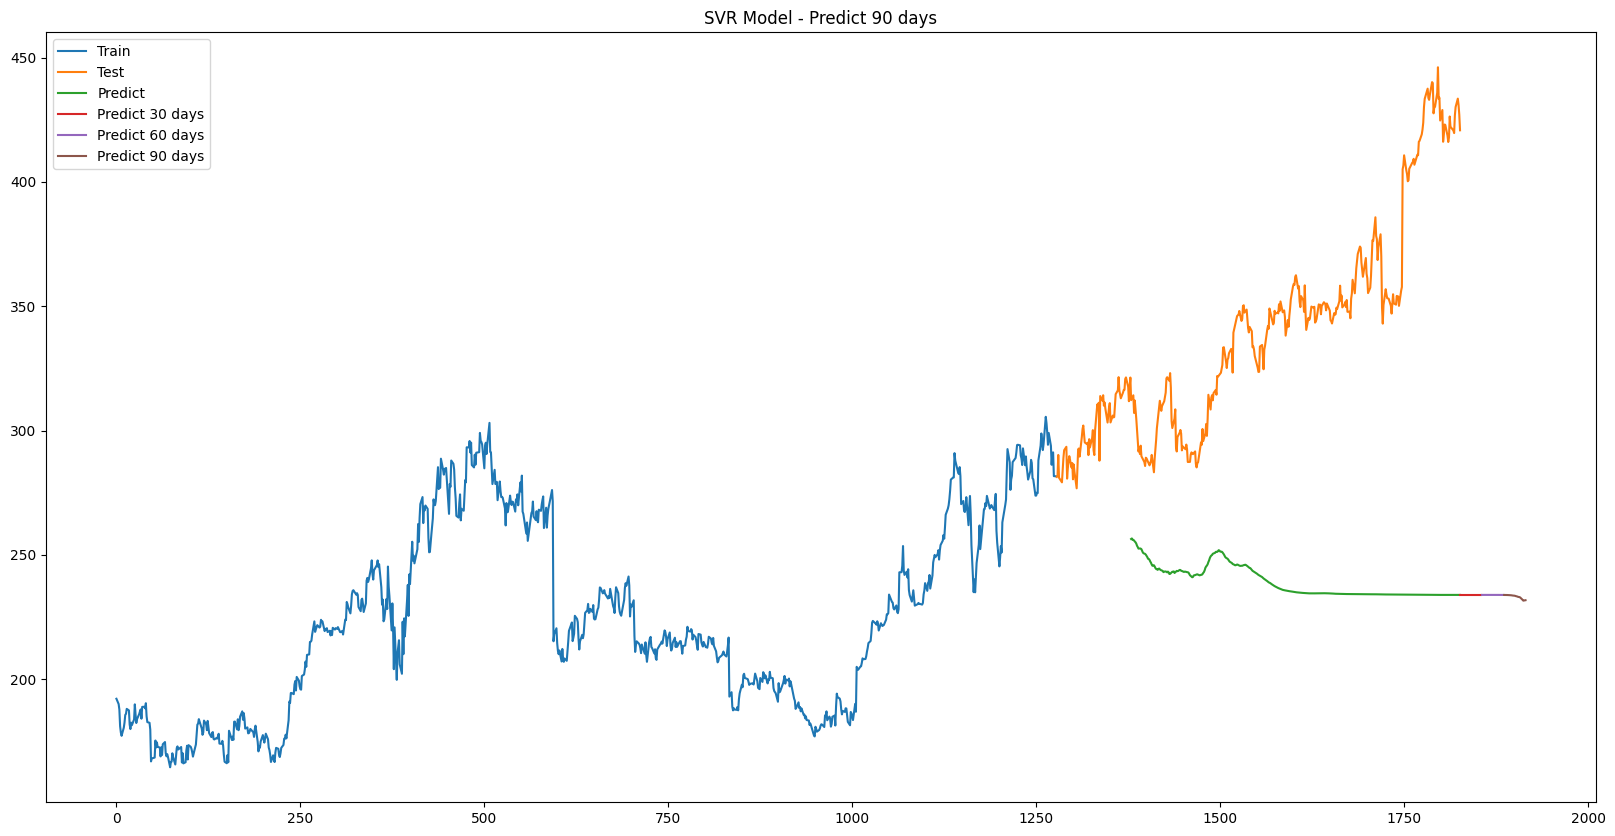

In [36]:
plt.figure(figsize=(20, 10))

# Plot training data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Plot testing data
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Plot predictions on the test set
test_pred_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(svr_y_pred.reshape(-1, 1)), label='Predict')

# Plot the next 90 days predictions, divided into three segments
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30, scaler.inverse_transform(svr_lst_output_90[:30]), label='Predict 30 days')

predict_data_index_60 = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60, scaler.inverse_transform(svr_lst_output_90[30:60]), label='Predict 60 days')

predict_data_index_90 = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90, scaler.inverse_transform(svr_lst_output_90[60:90]), label='Predict 90 days')

# Add legend and title
plt.legend()
plt.title("SVR Model - Predict 90 days")
plt.show()


## 5.3 Mô hình Linear Regression

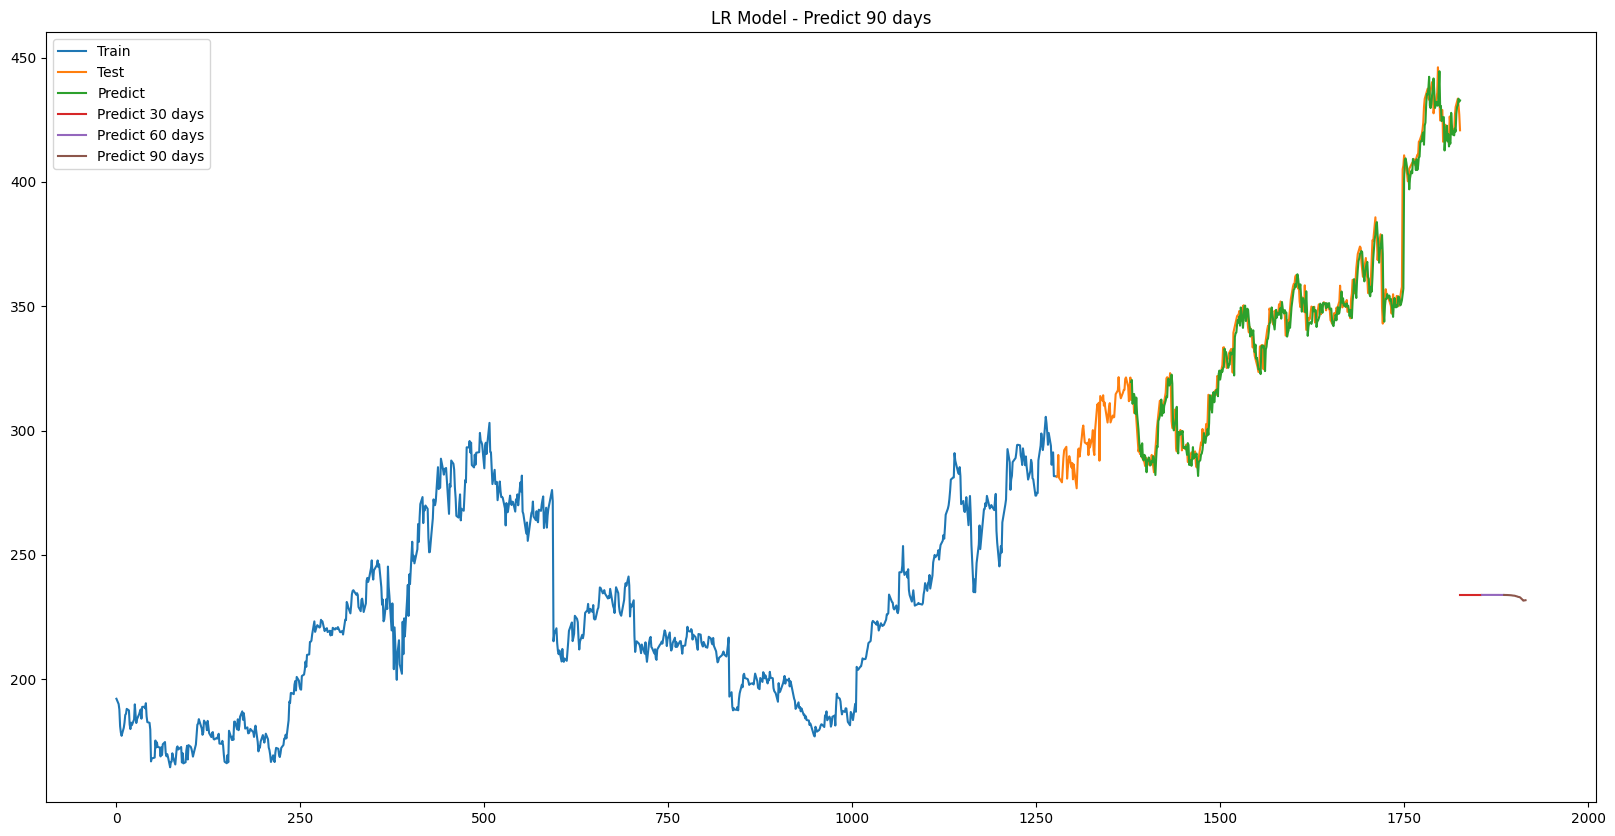

In [37]:
plt.figure(figsize=(20, 10))

# Plot training data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Plot testing data
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Plot predictions on the test set
test_pred_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(lr_y_pred.reshape(-1, 1)), label='Predict')

# Plot the next 90 days predictions, divided into three segments
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30, scaler.inverse_transform(lr_lst_output_90[:30]), label='Predict 30 days')

predict_data_index_60 = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60, scaler.inverse_transform(lr_lst_output_90[30:60]), label='Predict 60 days')

predict_data_index_90 = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90, scaler.inverse_transform(lr_lst_output_90[60:90]), label='Predict 90 days')

# Add legend and title
plt.legend()
plt.title("LR Model - Predict 90 days")
plt.show()


## 5.4 Mô hình Stacking 

## StackingSVR

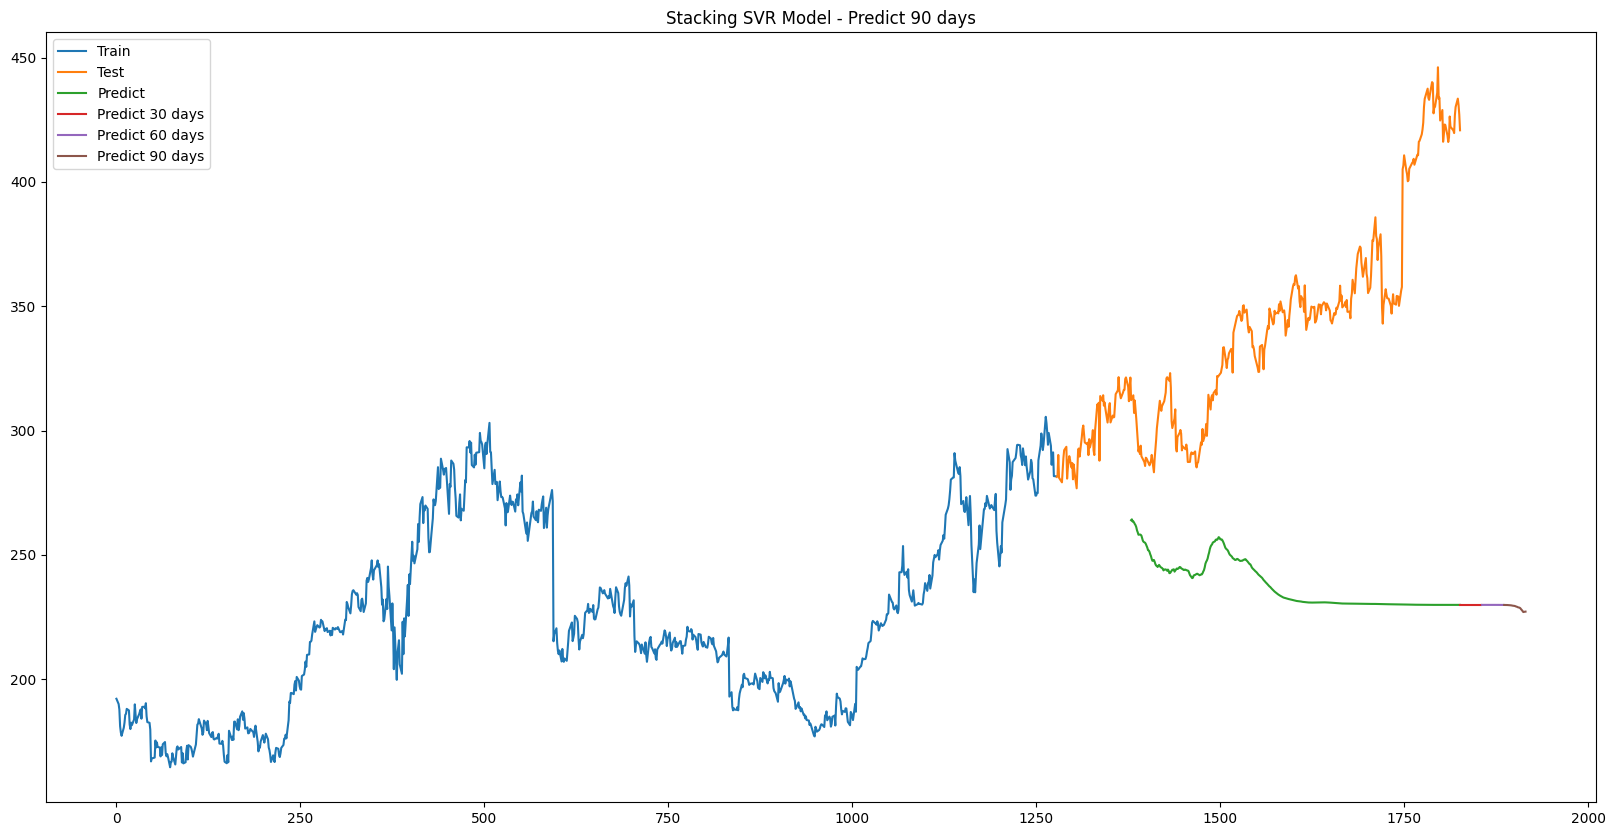

In [38]:
plt.figure(figsize=(20, 10))

# Plot training data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Plot testing data
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Plot predictions on the test set
test_pred_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(stackingSVR_y_pred.reshape(-1, 1)), label='Predict')

# Plot the next 90 days predictions, divided into three segments
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30, scaler.inverse_transform(stackingSVR_lst_output_90[:30]), label='Predict 30 days')

predict_data_index_60 = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60, scaler.inverse_transform(stackingSVR_lst_output_90[30:60]), label='Predict 60 days')

predict_data_index_90 = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90, scaler.inverse_transform(stackingSVR_lst_output_90[60:90]), label='Predict 90 days')

# Add legend and title
plt.legend()
plt.title("Stacking SVR Model - Predict 90 days")
plt.show()


## StackingRF

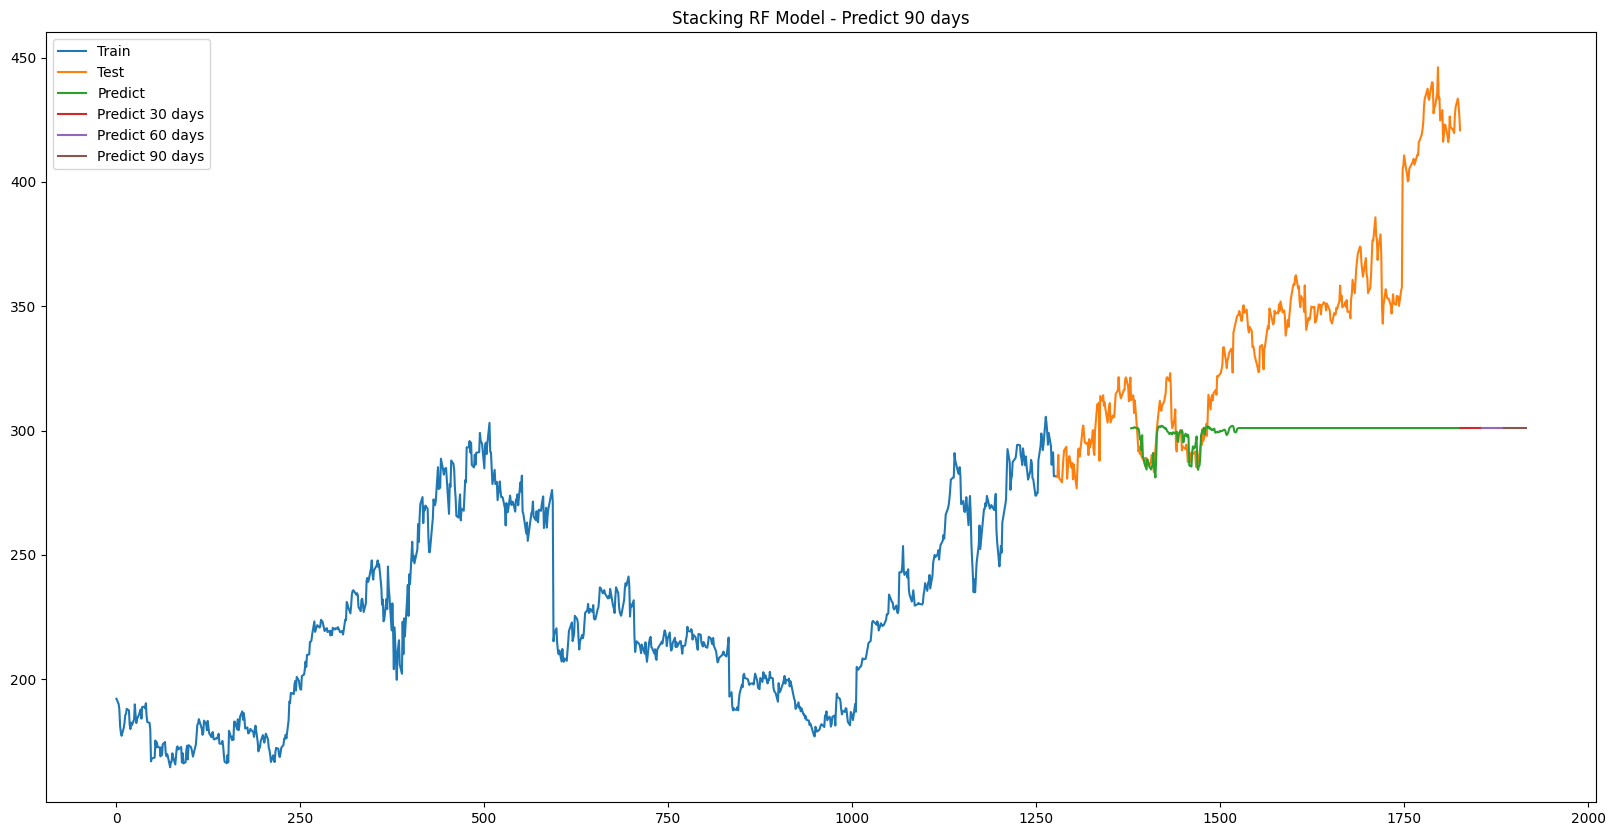

In [39]:
plt.figure(figsize=(20, 10))

# Plot training data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Plot testing data
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Plot predictions on the test set
test_pred_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(stackingRF_y_pred.reshape(-1, 1)), label='Predict')

# Plot the next 90 days predictions, divided into three segments
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30, scaler.inverse_transform(stackingRF_lst_output_90[:30]), label='Predict 30 days')

predict_data_index_60 = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60, scaler.inverse_transform(stackingRF_lst_output_90[30:60]), label='Predict 60 days')

predict_data_index_90 = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90, scaler.inverse_transform(stackingRF_lst_output_90[60:90]), label='Predict 90 days')

# Add legend and title
plt.legend()
plt.title("Stacking RF Model - Predict 90 days")
plt.show()
